# АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")


#### Предобработка

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Модели

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Метрики

In [4]:
from sklearn.metrics import auc, roc_curve


# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [5]:
data = pd.read_csv('Paribas.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [6]:
data.shape

(114321, 133)

#### Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [10]:
data.shape

(4573, 133)

In [12]:
X = data.drop(columns=['target'], axis=1)
y = data['target']


## Первичный анализ

Размер датасета

In [13]:
X

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
25072,50140,5.383119e-01,5.806123,C,2.556781,8.238692,2.327836,1.842871,0.475779,8.288288,...,5.675675,8.666571,0.368021,L,1.222328,1.236664,1.388536,0,2.336843,5.405397e-01
94654,189187,1.846308e+00,8.547472,C,4.386666,8.103564,2.754492,2.415170,0.040060,8.750000,...,7.291666,2.333860,0.001595,Y,1.387813,2.133234,2.124879,1,1.652892,2.000000e+00
48206,96289,9.212569e-01,12.396340,NaN,4.988039,8.894618,3.622783,3.062558,2.934179,7.000000,...,5.666667,1.302464,0.634999,Q,1.670340,1.832400,1.762071,0,1.008129,1.290323e+00
38407,76807,1.050142e+00,3.588558,C,1.642523,7.163292,1.759696,1.267738,1.385199,9.183673,...,5.170068,13.070161,0.933893,B,1.459492,2.039972,1.040078,0,6.507462,5.504592e-01
108396,216762,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CE,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,30733,9.319903e-01,9.427098,C,4.695188,7.222597,1.914357,2.015113,0.015869,10.499999,...,8.500000,1.970542,0.005403,H,1.368259,1.605793,1.717626,0,1.800000,1.111110e+00
23109,46178,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,CB,NaN,NaN,NaN,0,NaN,NaN
56138,112134,2.668647e+00,9.628883,C,5.182318,9.798109,2.511668,2.783199,0.851720,7.333333,...,6.545455,3.054928,0.644363,L,1.834476,1.384175,2.362711,0,1.317073,3.148147e+00
97697,195211,2.399125e-08,10.055013,C,5.414523,9.791526,2.171429,2.399999,0.015177,6.666667,...,5.490195,1.090010,0.009352,AY,1.800316,1.821428,4.144148,4,0.666666,-7.666254e-07


Распределение значений таргета (event rate)

In [14]:
y.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [15]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 25072 to 8203
Data columns (total 132 columns):
 #    Column  Dtype  
---   ------  -----  
 0    ID      int64  
 1    v1      float64
 2    v2      float64
 3    v3      object 
 4    v4      float64
 5    v5      float64
 6    v6      float64
 7    v7      float64
 8    v8      float64
 9    v9      float64
 10   v10     float64
 11   v11     float64
 12   v12     float64
 13   v13     float64
 14   v14     float64
 15   v15     float64
 16   v16     float64
 17   v17     float64
 18   v18     float64
 19   v19     float64
 20   v20     float64
 21   v21     float64
 22   v22     object 
 23   v23     float64
 24   v24     object 
 25   v25     float64
 26   v26     float64
 27   v27     float64
 28   v28     float64
 29   v29     float64
 30   v30     object 
 31   v31     object 
 32   v32     float64
 33   v33     float64
 34   v34     float64
 35   v35     float64
 36   v36     float64
 37   v37     float64
 38   v3

In [16]:
for c in X.columns:
    if (X[c].dtype == 'float64'):
        X[c].fillna(X[c].mean(), inplace=True)
    if (X[c].dtype == 'int64'):
        X[c].fillna(X[c].mean(), inplace=True)        
    if (X[c].dtype == 'object'):
        X[c].fillna('NULL', inplace=True) 
        

In [17]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 25072 to 8203
Data columns (total 132 columns):
 #    Column  Dtype  
---   ------  -----  
 0    ID      int64  
 1    v1      float64
 2    v2      float64
 3    v3      object 
 4    v4      float64
 5    v5      float64
 6    v6      float64
 7    v7      float64
 8    v8      float64
 9    v9      float64
 10   v10     float64
 11   v11     float64
 12   v12     float64
 13   v13     float64
 14   v14     float64
 15   v15     float64
 16   v16     float64
 17   v17     float64
 18   v18     float64
 19   v19     float64
 20   v20     float64
 21   v21     float64
 22   v22     object 
 23   v23     float64
 24   v24     object 
 25   v25     float64
 26   v26     float64
 27   v27     float64
 28   v28     float64
 29   v29     float64
 30   v30     object 
 31   v31     object 
 32   v32     float64
 33   v33     float64
 34   v34     float64
 35   v35     float64
 36   v36     float64
 37   v37     float64
 38   v3

In [18]:
for c in X.columns:
    if (X[c].dtype == 'object'):
      X[c] = X[c].astype('category')

In [19]:
X.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 25072 to 8203
Data columns (total 132 columns):
 #    Column  Dtype   
---   ------  -----   
 0    ID      int64   
 1    v1      float64 
 2    v2      float64 
 3    v3      category
 4    v4      float64 
 5    v5      float64 
 6    v6      float64 
 7    v7      float64 
 8    v8      float64 
 9    v9      float64 
 10   v10     float64 
 11   v11     float64 
 12   v12     float64 
 13   v13     float64 
 14   v14     float64 
 15   v15     float64 
 16   v16     float64 
 17   v17     float64 
 18   v18     float64 
 19   v19     float64 
 20   v20     float64 
 21   v21     float64 
 22   v22     category
 23   v23     float64 
 24   v24     category
 25   v25     float64 
 26   v26     float64 
 27   v27     float64 
 28   v28     float64 
 29   v29     float64 
 30   v30     category
 31   v31     category
 32   v32     float64 
 33   v33     float64 
 34   v34     float64 
 35   v35     float64 
 36   v36     

In [20]:
XX = X.copy()

In [21]:
#print(XX.value_counts())

In [22]:
for c in XX.columns:
  if (XX[c].dtype.name == 'category'):
    if (len(XX[c].unique()) > 29):
      print('{0} -- {1}'.format(c, len(XX[c].unique())))

v22 -- 2794
v56 -- 76
v113 -- 35
v125 -- 89


WoE использовался в основном в финансовом секторе для создания оценочных карт кредитного риска.

Кодер будет кодировать только категориальные переменные (типа «объект»). В качестве аргумента может быть передан список переменных. Если переменные не переданы, кодировщик найдет и закодирует все категориальные переменные (тип объекта).

Кодер сначала сопоставляет категории с весом свидетельства для каждой переменной (соответствие). Затем кодировщик преобразует категории в сопоставленные числа (преобразование).

In [23]:
from category_encoders.woe import WOEEncoder

In [24]:
enc = WOEEncoder(cols=['v22', 'v56', 'v113', 'v125'], return_df=True)

In [25]:
XX2 = enc.fit_transform(XX, y)

In [26]:
XX['v22']

25072      BEO
94654       ZR
48206      FCR
38407      XAZ
108396     TMU
          ... 
15315      KMF
23109       PS
56138     AEAB
97697     AEYO
8203       YDK
Name: v22, Length: 4573, dtype: category
Categories (2794, object): ['AAAB', 'AAAF', 'AAAH', 'AABI', ..., 'ZZK', 'ZZN', 'ZZW', 'ZZZ']

In [27]:
XX2['v22']

25072    -0.059441
94654     0.000000
48206     0.000000
38407     0.451385
108396    0.000000
            ...   
15315     0.000000
23109     0.000000
56138     0.000000
97697     0.000000
8203      0.000000
Name: v22, Length: 4573, dtype: float64

In [28]:
XX['v22']

25072      BEO
94654       ZR
48206      FCR
38407      XAZ
108396     TMU
          ... 
15315      KMF
23109       PS
56138     AEAB
97697     AEYO
8203       YDK
Name: v22, Length: 4573, dtype: category
Categories (2794, object): ['AAAB', 'AAAF', 'AAAH', 'AABI', ..., 'ZZK', 'ZZN', 'ZZW', 'ZZZ']

In [29]:
for c in X.columns:
  if (X[c].dtype.name == 'category'):
    if (len(X[c].unique()) > 29):
      X.drop(c, axis=1, inplace=True)
        

In [30]:
X = pd.get_dummies(X)

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4573 entries, 25072 to 8203
Columns: 223 entries, ID to v112_V
dtypes: float64(108), int64(5), uint8(110)
memory usage: 4.6 MB


In [32]:
X.shape

(4573, 223)

In [33]:
X

,ID,v1,v2,v4,v5,v6,v7,v8,v9,v10,...,v112_N,v112_NULL,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V
25072,50140,5.383119e-01,5.806123,2.556781,8.238692,2.327836,1.842871,0.475779,8.288288,1.291029,...,0,0,0,0,0,0,0,0,0,0
94654,189187,1.846308e+00,8.547472,4.386666,8.103564,2.754492,2.415170,0.040060,8.750000,5.229760,...,0,0,0,0,0,0,0,0,0,0
48206,96289,9.212569e-01,12.396340,4.988039,8.894618,3.622783,3.062558,2.934179,7.000000,5.251642,...,0,0,0,0,0,1,0,0,0,0
38407,76807,1.050142e+00,3.588558,1.642523,7.163292,1.759696,1.267738,1.385199,9.183673,1.050327,...,0,0,0,0,0,0,0,0,0,0
108396,216762,1.623295e+00,7.409287,4.122779,8.738128,2.446556,2.497578,1.561155,9.014468,1.312911,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,30733,9.319903e-01,9.427098,4.695188,7.222597,1.914357,2.015113,0.015869,10.499999,0.897156,...,0,0,0,1,0,0,0,0,0,0
23109,46178,1.623295e+00,7.409287,4.122779,8.738128,2.446556,2.497578,1.561155,9.014468,1.312911,...,0,0,0,0,0,0,0,1,0,0
56138,112134,2.668647e+00,9.628883,5.182318,9.798109,2.511668,2.783199,0.851720,7.333333,0.503282,...,0,0,0,0,0,0,0,0,0,0
97697,195211,2.399125e-08,10.055013,5.414523,9.791526,2.171429,2.399999,0.015177,6.666667,4.442014,...,0,0,0,0,1,0,0,0,0,0


X

#### Функция для подсчета  ROC AUC и постройки графика

In [34]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [35]:
X.drop('ID', axis=1, inplace=True)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Логистическая регрессия

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
y_train

10862    1
26654    1
34826    1
8753     0
41842    1
        ..
18455    1
69284    1
11329    1
50653    1
62797    1
Name: target, Length: 3658, dtype: int64

In [39]:
model = LogisticRegression().fit(X_train, y_train)
model.score(X_test, y_test)

0.7759562841530054

ROC AUC: 0.7220


0.7219620667102682

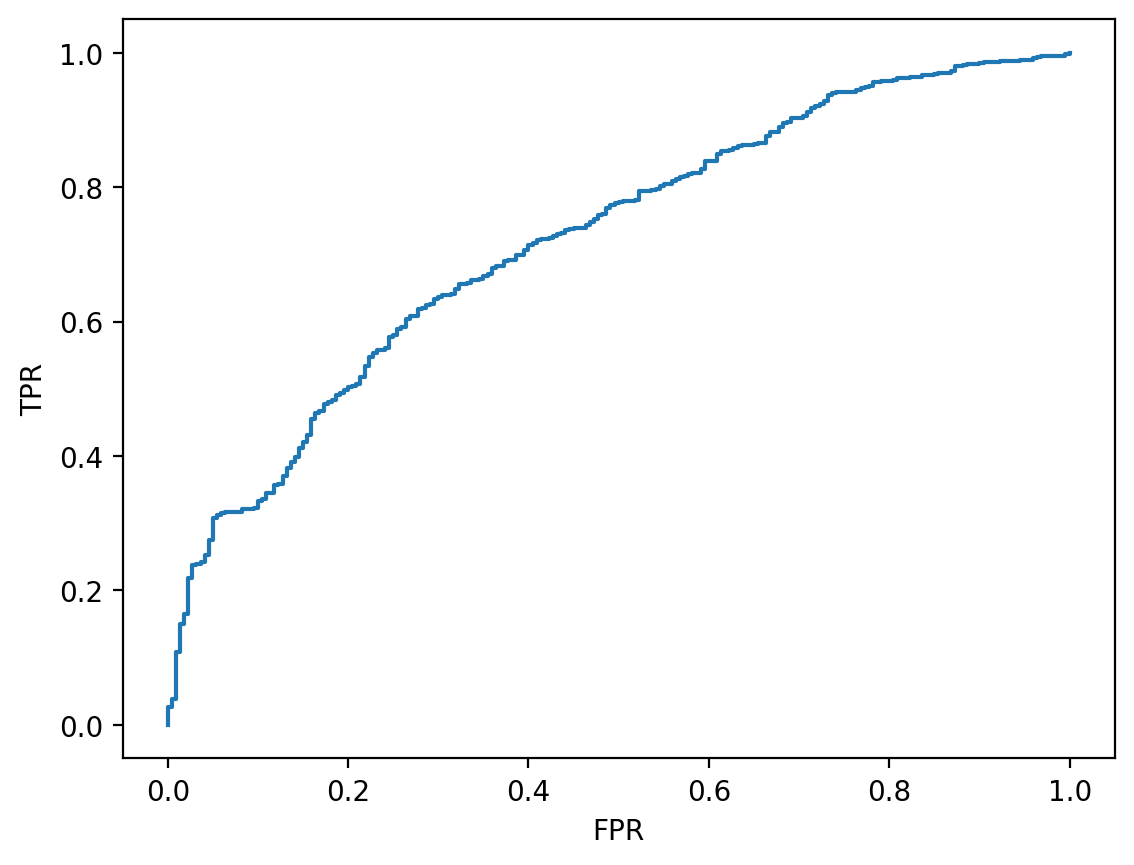

In [40]:
calc_auc(y_test, model.predict_proba(X_test)[:,1], plot_label='LR')

### Решающее дерево

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> хороший выбор для построения композиций


Обучаем решающее дерево

Ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

Предсказываем вероятность класса 1 и считаем ROC AUC

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression(solver="liblinear", random_state=42)
#svm_clf = SVC(gamma="auto", probability=True, random_state=42)
rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
knn_1 = KNeighborsClassifier(n_neighbors=5)
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=500, min_samples_split=2, max_depth=7, max_features=0.8, max_leaf_nodes=16, min_samples_leaf=20, n_jobs=-1, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf),  ('rf_1', rf_1), ('knn_1', knn_1)],
    voting='soft')

In [50]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf_1', RandomForestClassifier(random_state=42)),
                             ('knn_1', KNeighborsClassifier())],
                 voting='soft')

In [51]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, dtr_clf,rf_1,knn_1, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.766120218579235
DecisionTreeClassifier 0.6983606557377049
RandomForestClassifier 0.780327868852459
KNeighborsClassifier 0.7180327868852459
VotingClassifier 0.7573770491803279


In [87]:
staking_clf = StackingClassifier(
    estimators=[('lr', log_clf),  ('rf_1', rf_1), ('knn_1', knn_1),('et',et)],
    final_estimator=log_clf, n_jobs=-1, verbose=3)

In [88]:
staking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(random_state=42,
                                                   solver='liblinear')),
                               ('rf_1',
                                RandomForestClassifier(random_state=42)),
                               ('knn_1', KNeighborsClassifier()),
                               ('et',
                                ExtraTreesClassifier(max_depth=7,
                                                     max_features=0.8,
                                                     max_leaf_nodes=16,
                                                     min_samples_leaf=20,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42))],
                   final_estimator=LogisticRegression(random_state=42,
                                                      solver='liblinear'),
                   n_jobs=-1, verbose=3)

In [89]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rf_1,knn_1,et, staking_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.766120218579235
DecisionTreeClassifier 0.6983606557377049
RandomForestClassifier 0.780327868852459
KNeighborsClassifier 0.7180327868852459
ExtraTreesClassifier 0.7781420765027323
StackingClassifier 0.7770491803278688


ROC AUC: 0.7370


0.7370176586003925

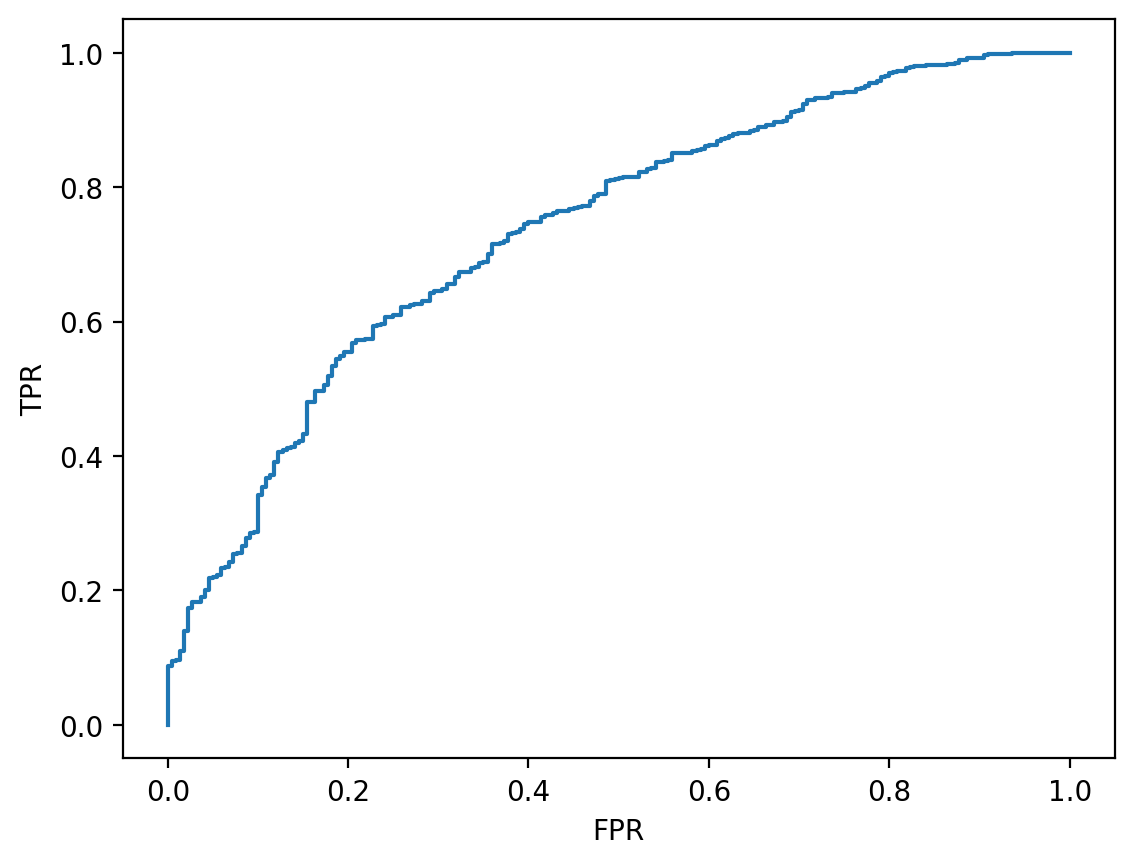

In [90]:
calc_auc(y_test, staking_clf.predict_proba(X_test)[:,1], plot_label='LR')

### Классификатор с голосованием

In [44]:
from sklearn.ensemble import VotingClassifier

## Композиции моделей одного семейства

### Бэггинг

Самостоятельная реализация

##### На дереве

In [70]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.7672131147540984


In [71]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.6983606557377049


##### Логистический

# Часть 2. Случайный лес


**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [72]:
%%time
from sklearn.ensemble import RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


In [66]:
%%time

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=3, max_leaf_nodes=16, n_jobs=-1, random_state=42) # min_samples_split=14,
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.7595628415300546
CPU times: total: 2.94 s
Wall time: 1.01 s


In [67]:
X_test

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v112_N,v112_NULL,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V
75546,1.623295e+00,7.409287,4.122779,8.738128,2.446556,2.497578,1.561155,9.014468,1.028447,15.433965,...,0,0,0,0,0,0,0,0,0,0
12184,7.283459e-01,11.923393,4.862246,6.745125,2.204724,2.362205,0.022186,10.270269,1.553611,16.416666,...,0,0,0,0,0,0,0,0,0,0
9266,1.623295e+00,7.409287,4.122779,8.738128,2.446556,2.497578,1.561155,9.014468,0.919037,15.433965,...,0,0,0,0,0,0,0,0,0,0
84222,2.273219e+00,7.747976,4.253893,8.193342,2.428623,2.399711,1.703669,8.445747,1.291028,15.294954,...,0,0,0,0,0,0,0,0,0,0
12550,-7.259846e-07,4.002613,4.176409,8.225611,2.283981,2.657907,1.507072,11.048951,5.054704,16.181383,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13313,1.375466e+00,5.569668,3.450255,6.758574,2.267658,2.769517,0.042679,10.393701,1.312911,15.435992,...,0,0,0,0,0,0,0,0,0,0
30960,1.623295e+00,7.409287,4.122779,8.738128,2.446556,2.497578,1.561155,9.014468,1.312911,15.433965,...,0,0,0,0,0,0,0,0,0,0
102425,1.461214e+00,8.635587,4.292461,10.537996,2.064880,2.944992,0.160698,10.572206,2.625820,15.615763,...,0,0,0,0,0,0,0,0,0,0
71712,2.369458e+00,5.813469,3.338985,8.738128,1.241379,2.492611,1.561155,9.298245,0.656456,14.765507,...,0,0,0,0,0,0,0,0,0,0


In [68]:
rnd_clf.predict_proba(X_test)[:,0]

array([0.21991335, 0.22827621, 0.32760276, 0.23836394, 0.11295022,
       0.33705979, 0.17206273, 0.13508287, 0.22283397, 0.25538972,
       0.26784208, 0.27544352, 0.13983962, 0.21177317, 0.22664055,
       0.18755643, 0.16807026, 0.33008915, 0.32526264, 0.11456292,
       0.28093291, 0.28744802, 0.24663899, 0.2138116 , 0.28877345,
       0.32897858, 0.28265545, 0.1256982 , 0.11110447, 0.17211635,
       0.24409996, 0.23999106, 0.26655541, 0.2736691 , 0.23570739,
       0.26056966, 0.16940911, 0.22614851, 0.20073338, 0.13273424,
       0.15667522, 0.28842081, 0.30697145, 0.3231956 , 0.31699063,
       0.11349303, 0.13598066, 0.26299114, 0.28913929, 0.26798176,
       0.2896689 , 0.24254023, 0.23298502, 0.28875325, 0.25603994,
       0.2326918 , 0.23648007, 0.27884013, 0.22520918, 0.26885069,
       0.30690952, 0.28045926, 0.1085287 , 0.23334498, 0.27263289,
       0.26185116, 0.2968694 , 0.10932489, 0.12708443, 0.22972796,
       0.27564936, 0.11096581, 0.27585397, 0.20169621, 0.25369

ROC AUC: 0.6858


0.6858404185742315

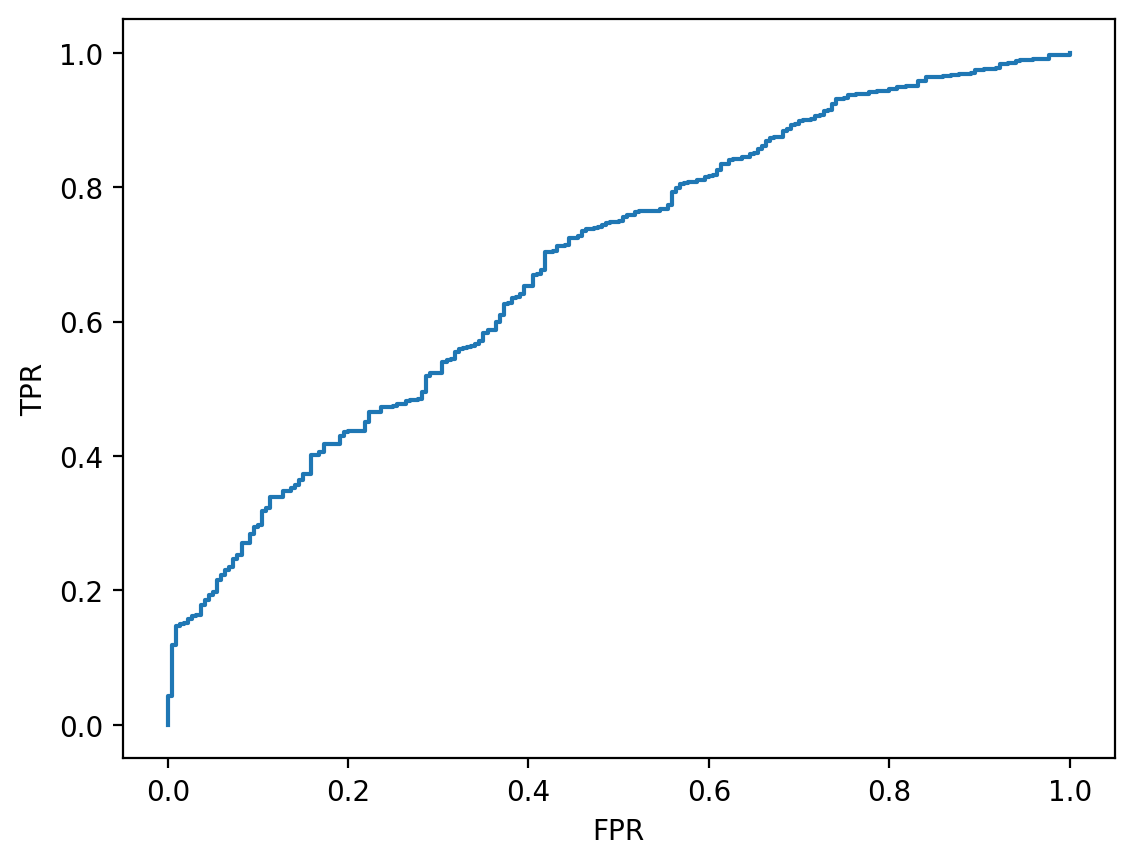

In [69]:
calc_auc(y_test, rnd_clf.predict_proba(X_test)[:,1], plot_label='T')

In [73]:
from sklearn.decomposition import PCA

In [74]:
y = data['target']

In [76]:
pca = PCA(n_components=50)
X2 = pca.fit_transform(X)

In [77]:
X2.shape

(4573, 50)

In [78]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [79]:
%%time
rnd_clf2 = RandomForestClassifier(n_estimators=500, min_samples_split=14, max_depth=3, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf2.fit(X_train2, y_train2)

y_pred_rf2 = rnd_clf2.predict(X_test2)
print(accuracy_score(y_test2, y_pred_rf2))

0.7595628415300546
CPU times: total: 4.2 s
Wall time: 1.19 s


ROC AUC: 0.6819


0.681890124264225

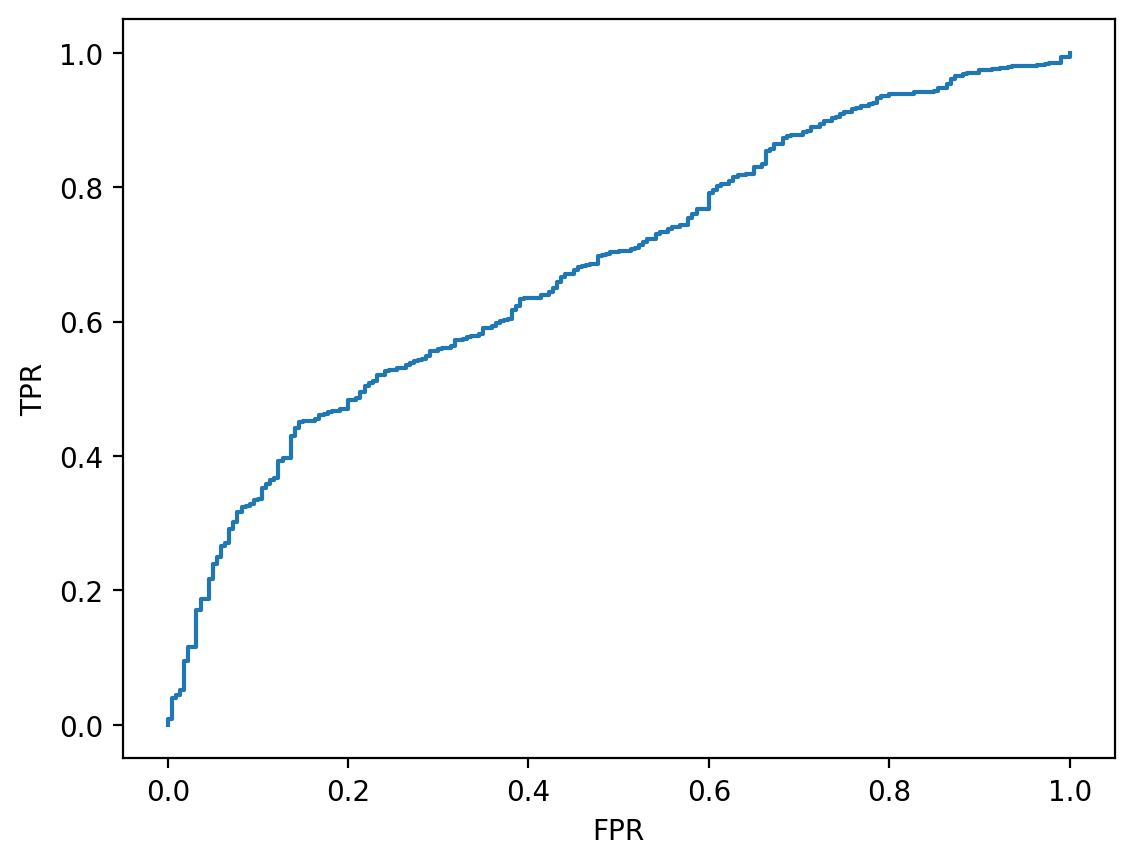

In [80]:
calc_auc(y_test2, rnd_clf2.predict_proba(X_test2)[:,1], plot_label='T')

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

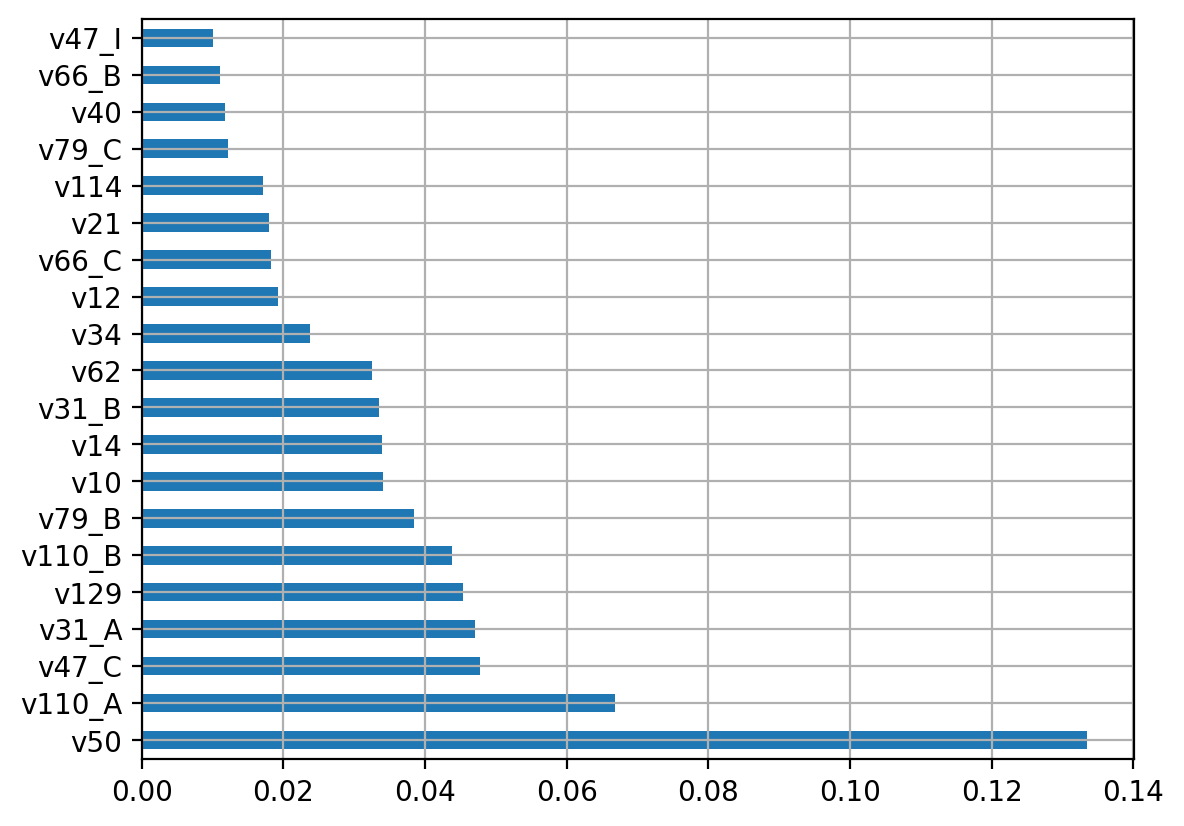

In [81]:
imp = pd.Series(rnd_clf.feature_importances_, index=X_test.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

Этот класс реализует метаоценщик, который соответствует ряду рандомизированных деревьев решений (также называемых дополнительными деревьями) для различных подвыборок набора данных и использует усреднение для повышения точности прогнозирования и контроля переобучения.

In [85]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_estimators=500, min_samples_split=2, max_depth=7, max_features=0.8, max_leaf_nodes=16, min_samples_leaf=20, n_jobs=-1, random_state=42)
et.fit(X_train, y_train)

y_pred_et = et.predict(X_test)
print(accuracy_score(y_test, y_pred_et))

0.7781420765027323


ROC AUC: 0.7257


0.7257325049051667

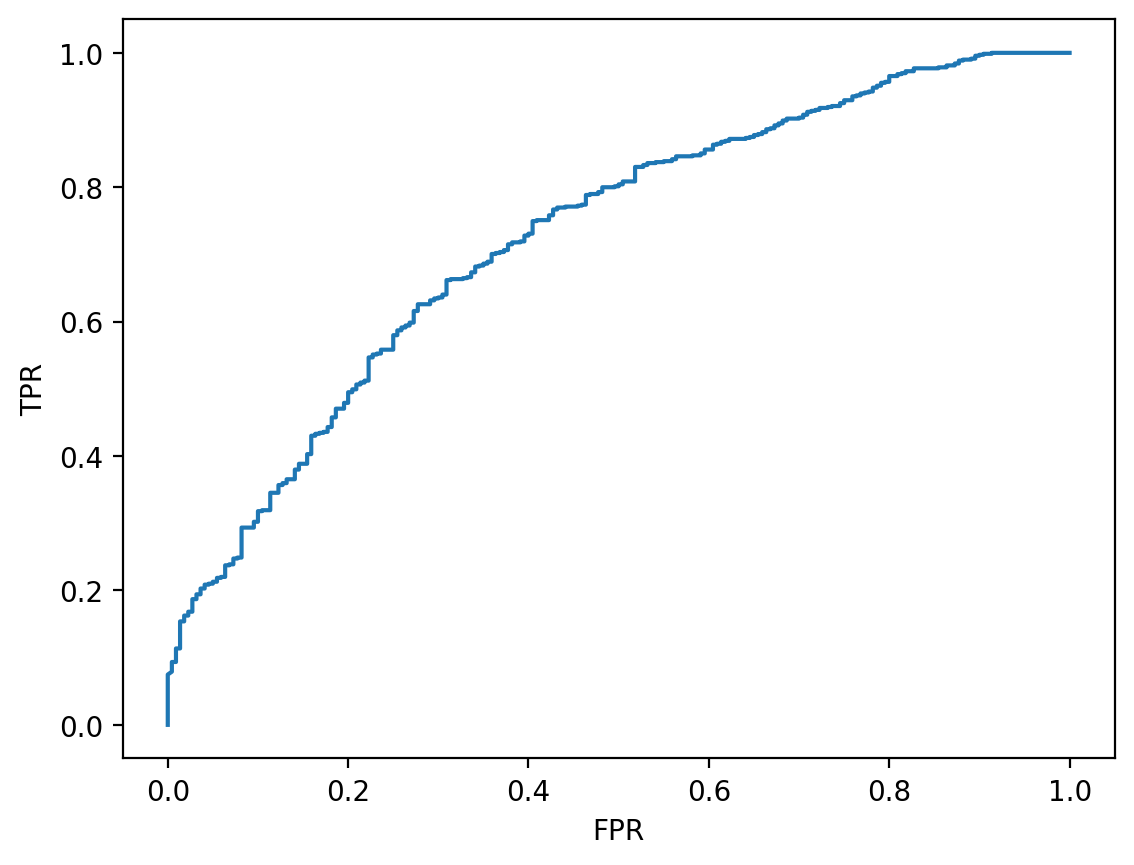

In [86]:
calc_auc(y_test, et.predict_proba(X_test)[:,1], plot_label='T')

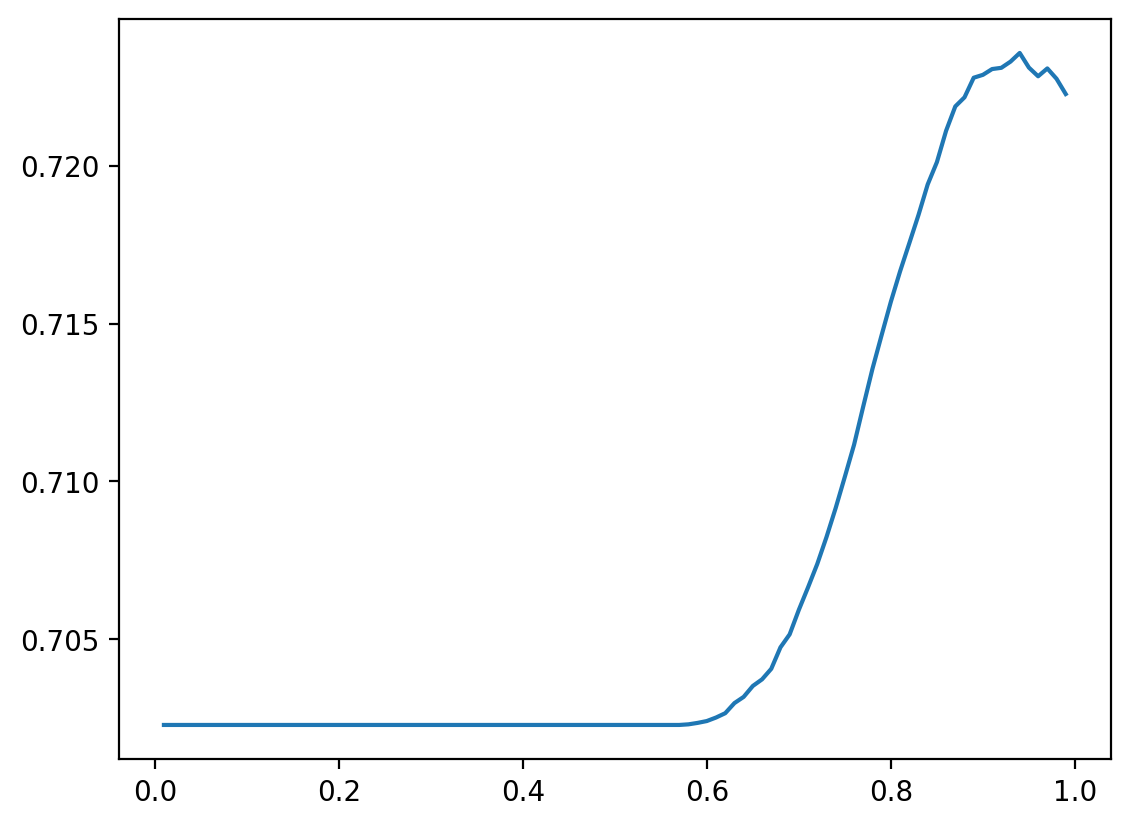

In [91]:
y = []
x = []

log_pred = log_clf.fit(X_train, y_train).predict_proba(X_test)
et_pred = dtr_clf.fit(X_train, y_train).predict_proba(X_test)

for i in range(1, 100):
    a = i * 0.01
    x.append(a)
    y.append(calc_auc(y_test, a * log_pred[:,1] + (1 - a) * et_pred[:, 1], prin=False))
    
plt.plot(x, y)

StackingClassifier - Стек оценок с окончательным классификатором.

Обобщение с накоплением состоит в суммировании выходных данных отдельного оценщика и использовании классификатора для вычисления окончательного прогноза. Наложение позволяет использовать силу каждого отдельного оценщика, используя их выходные данные в качестве входных данных для окончательного оценщика.

In [92]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

estimators = [
     ('rf', rnd_clf),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42))),
     ('lr', log_clf)
]

clf = StackingClassifier(
     estimators=estimators, final_estimator=et
)

clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=3,
                                                       max_leaf_nodes=16,
                                                       n_estimators=500,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('svr',
                                Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('linearsvc',
                                                 LinearSVC(random_state=42))])),
                               ('lr',
                                LogisticRegression(random_state=42,
                                                   solver='liblinear'))],
                   final_estimator=ExtraTreesClassifier(max_depth=7,
                                                        max_features=0.8,
                                                        max_leaf_nodes=16,
                                                        min_samples_leaf=20,
                                                        n_estimators=500,
                                                        n_jobs=-1,
                                                        random_state=42))

In [95]:
clf.score(X_test, y_test)

0.7595628415300546

ROC AUC: 0.7170


0.7170045781556573

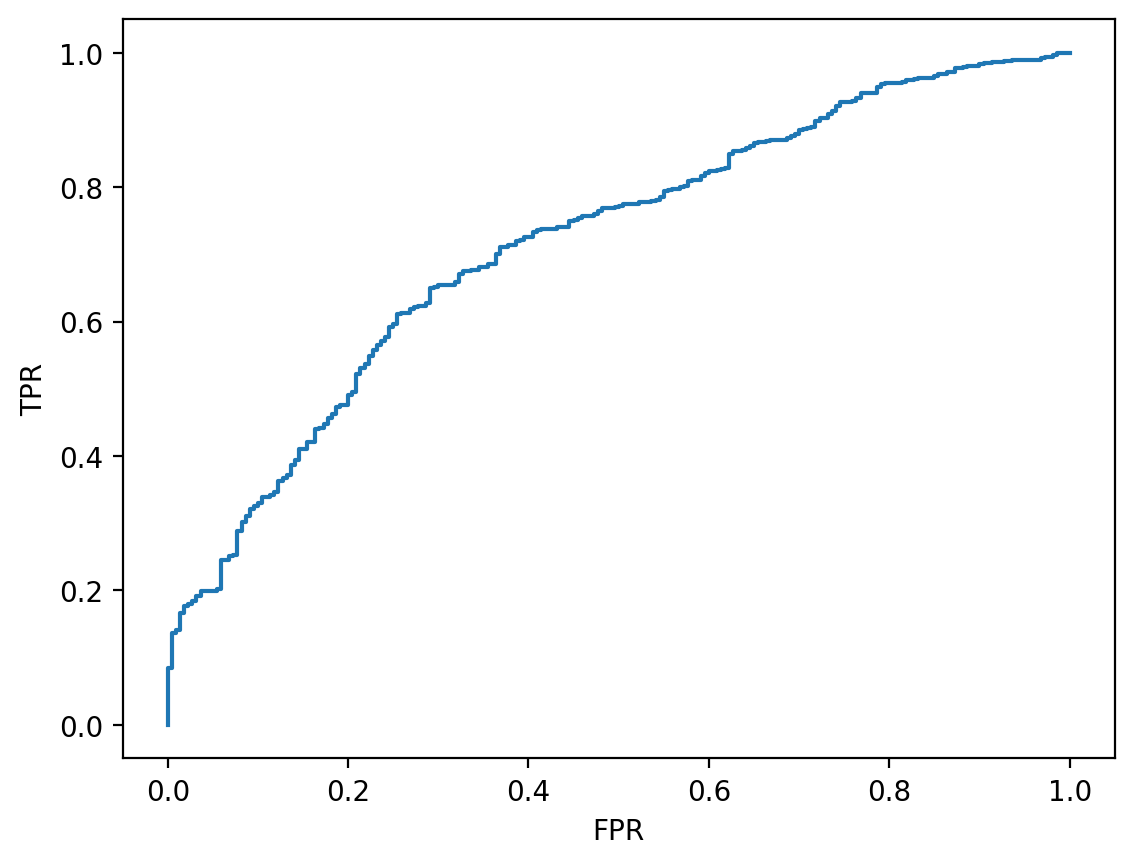

In [96]:
calc_auc(y_test, clf.predict_proba(X_test)[:,1], plot_label='T')

AdaBoosting

In [97]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

Train:
ROC AUC: 0.8268
Test:
ROC AUC: 0.7208


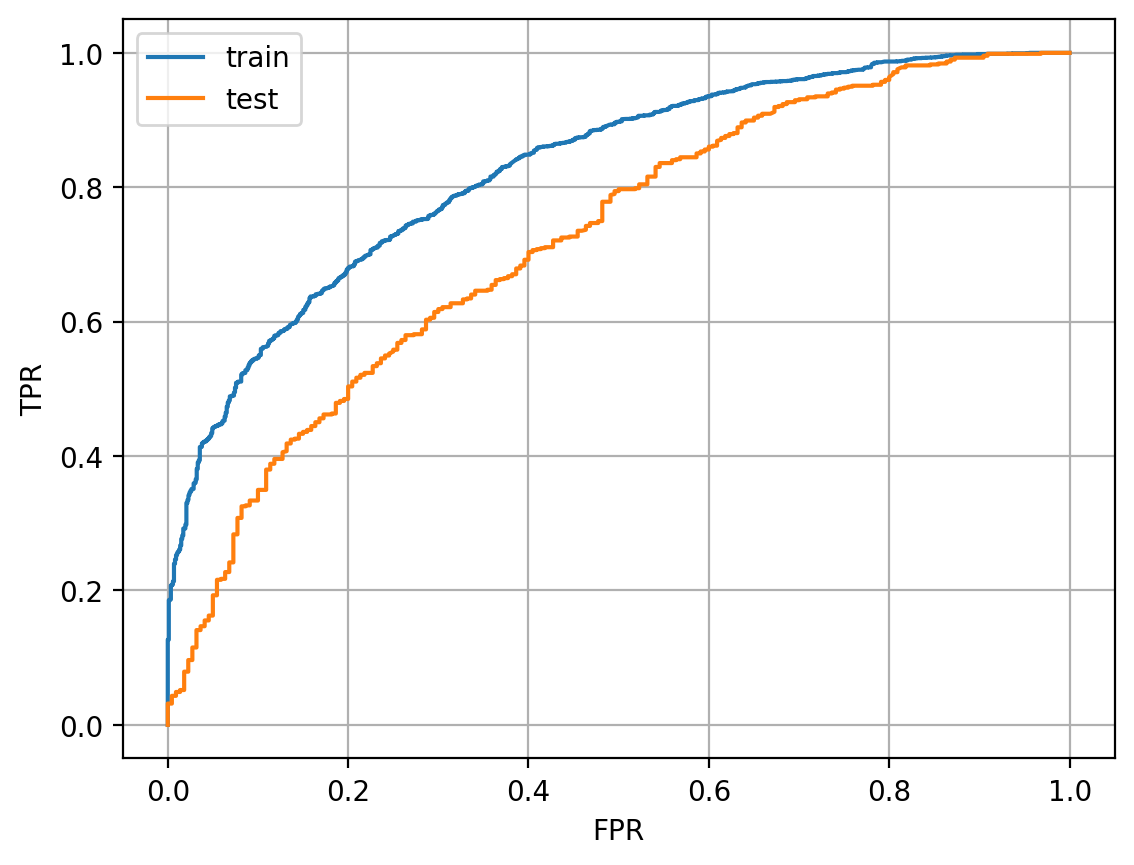

In [98]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=30, max_features=0.8, min_samples_split=30),
                             n_estimators=100, learning_rate=0.1, random_state=42)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.grid();
plt.legend();

Gradient Boosting

Train:
ROC AUC: 0.8106
Test:
ROC AUC: 0.7313
CPU times: total: 3.44 s
Wall time: 3.47 s


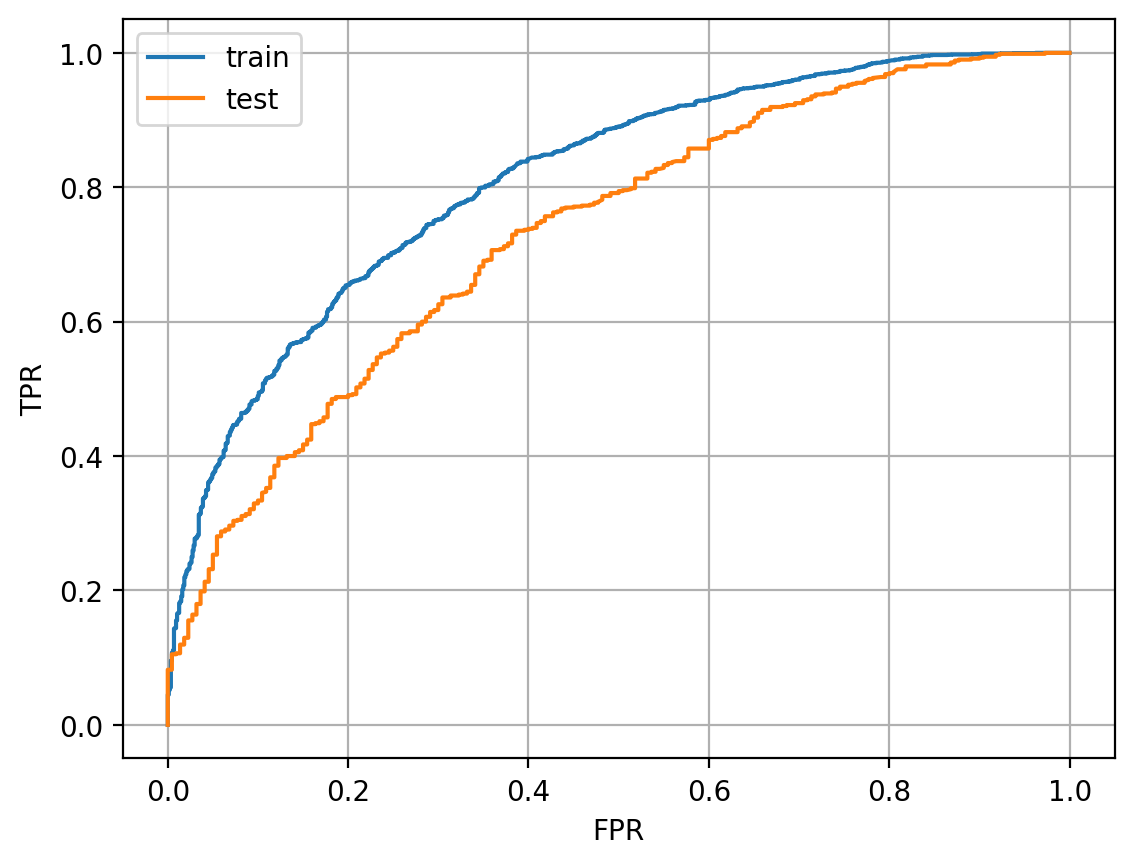

In [100]:
%%time
clf_gbm = GradientBoostingClassifier(max_depth=2, min_samples_leaf=30, n_estimators=100, learning_rate=0.1, 
                                     subsample=1.0, max_features=0.8, min_samples_split=30, random_state=42, 
                                     verbose=0)
# если subsample < 1.0 - получится стахастический градиентный спуск, алгоритм работать будет быстрее, 
# но точность может быть хуже

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend()
plt.grid();

In [101]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [77]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

In [78]:
%%time
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

Wall time: 1.87 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7288


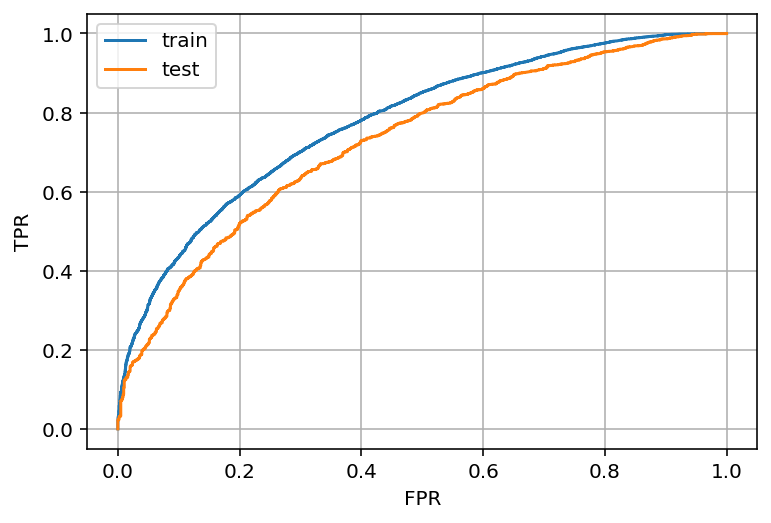

In [79]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

In [80]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69899	validation_1-auc:0.68220
[1]	validation_0-auc:0.70214	validation_1-auc:0.68661
[2]	validation_0-auc:0.71651	validation_1-auc:0.69848
[3]	validation_0-auc:0.71977	validation_1-auc:0.70079
[4]	validation_0-auc:0.72146	validation_1-auc:0.70319
[5]	validation_0-auc:0.72239	validation_1-auc:0.70508
[6]	validation_0-auc:0.72319	validation_1-auc:0.70615
[7]	validation_0-auc:0.72251	validation_1-auc:0.70663
[8]	validation_0-auc:0.72414	validation_1-auc:0.70771
[9]	validation_0-auc:0.72626	validation_1-auc:0.70975
[10]	validation_0-auc:0.72650	validation_1-auc:0.71028
[11]	validation_0-auc:0.72765	validation_1-auc:0.71128
[12]	validation_0-auc:0.72921	validation_1-auc:0.71196
[13]	validation_0-auc:0.72935	validation_1-auc:0.71191
[14]	validation_0-auc:0.73040	validation_1-auc:0.71300
[15]	validation_0-auc:0.73285	validation_1-auc:0.71456
[16]	validation_0-auc:0.73426	validation_1-auc:0.71494
[17]	validation_0-auc:0.73497	validation_1-auc:0.71468
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7288


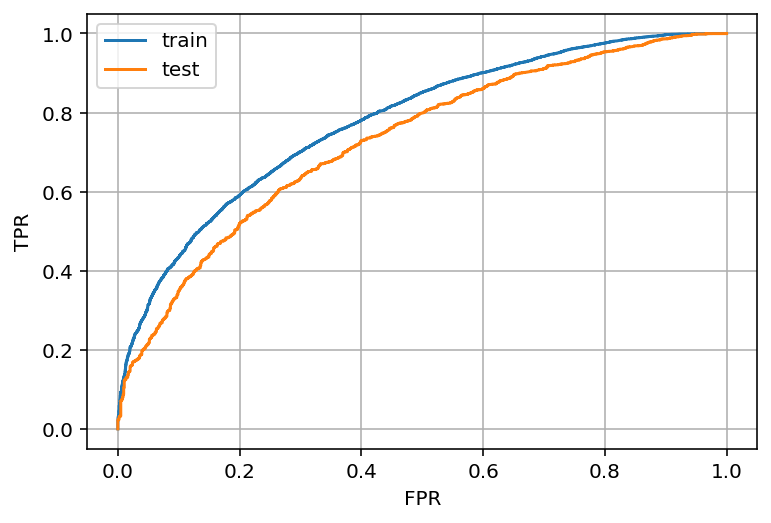

In [53]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

In [54]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69899	validation_1-auc:0.68220
[1]	validation_0-auc:0.70214	validation_1-auc:0.68661
[2]	validation_0-auc:0.71651	validation_1-auc:0.69848
[3]	validation_0-auc:0.71977	validation_1-auc:0.70079
[4]	validation_0-auc:0.72146	validation_1-auc:0.70319
[5]	validation_0-auc:0.72239	validation_1-auc:0.70508
[6]	validation_0-auc:0.72319	validation_1-auc:0.70615
[7]	validation_0-auc:0.72251	validation_1-auc:0.70663
[8]	validation_0-auc:0.72414	validation_1-auc:0.70771
[9]	validation_0-auc:0.72626	validation_1-auc:0.70975
[10]	validation_0-auc:0.72650	validation_1-auc:0.71028
[11]	validation_0-auc:0.72765	validation_1-auc:0.71128
[12]	validation_0-auc:0.72921	validation_1-auc:0.71196
[13]	validation_0-auc:0.72935	validation_1-auc:0.71191
[14]	validation_0-auc:0.73040	validation_1-auc:0.71300
[15]	validation_0-auc:0.73285	validation_1-auc:0.71456
[16]	validation_0-auc:0.73426	validation_1-auc:0.71494
[17]	validation_0-auc:0.73496	validation_1-auc:0.71468
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [81]:
%%time

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.72892	validation_1-auc:0.69742
[1]	validation_0-auc:0.73976	validation_1-auc:0.70759
[2]	validation_0-auc:0.74278	validation_1-auc:0.70771
[3]	validation_0-auc:0.74526	validation_1-auc:0.70777
[4]	validation_0-auc:0.75155	validation_1-auc:0.71185
[5]	validation_0-auc:0.75396	validation_1-auc:0.71296
[6]	validation_0-auc:0.75614	validation_1-auc:0.71238
[7]	validation_0-auc:0.75740	validation_1-auc:0.71520
[8]	validation_0-auc:0.76087	validation_1-auc:0.71547
[9]	validation_0-auc:0.76211	validation_1-auc:0.71629
[10]	validation_0-auc:0.76348	validation_1-auc:0.71771
[11]	validation_0-auc:0.76457	validation_1-auc:0.71896
[12]	validation_0-auc:0.76563	validation_1-auc:0.71958
[13]	validation_0-auc:0.76644	validation_1-auc:0.72065
[14]	validation_0-auc:0.76808	validation_1-auc:0.72033
[15]	validation_0-auc:0.76978	validation_1-auc:0.72047
[16]	validation_0-auc:0.77051	validation_1-auc:0.72013
[17]	validation_0-auc:0.77131	validation_1-auc:0.72064
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

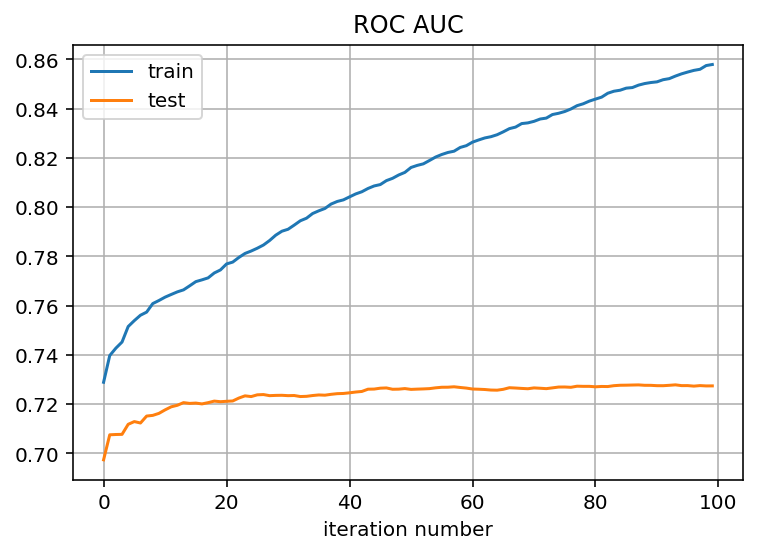

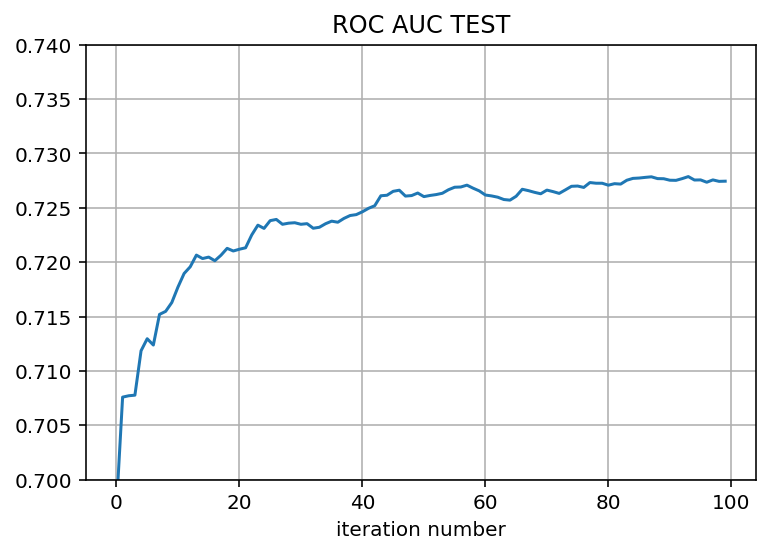

In [82]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.7, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

In [83]:
%%time
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.72892	validation_1-auc:0.69742
[1]	validation_0-auc:0.73653	validation_1-auc:0.70623
[2]	validation_0-auc:0.74068	validation_1-auc:0.70614
[3]	validation_0-auc:0.74188	validation_1-auc:0.70625
[4]	validation_0-auc:0.74668	validation_1-auc:0.71244
[5]	validation_0-auc:0.74835	validation_1-auc:0.71381
[6]	validation_0-auc:0.75073	validation_1-auc:0.71515
[7]	validation_0-auc:0.75195	validation_1-auc:0.71636
[8]	validation_0-auc:0.75334	validation_1-auc:0.71746
[9]	validation_0-auc:0.75412	validation_1-auc:0.71786
[10]	validation_0-auc:0.75438	validation_1-auc:0.71808
[11]	validation_0-auc:0.75488	validation_1-auc:0.71795
[12]	validation_0-auc:0.75513	validation_1-auc:0.71804
[13]	validation_0-auc:0.75561	validation_1-auc:0.71774
[14]	validation_0-auc:0.75640	validation_1-auc:0.71826
[15]	validation_0-auc:0.75733	validation_1-auc:0.71922
[16]	validation_0-auc:0.75797	validation_1-auc:0.71927
[17]	validation_0-auc:0.75798	validation_1-auc:0.71972
[18]	validation_0-au

In [84]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

In [85]:
%%time

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1] END ..max_depth=3, min_child_weight=10;, score=0.715 total time=   0.7s
[CV 1/1] END ..max_depth=3, min_child_weight=20;, score=0.715 total time=   0.7s
[CV 1/1] END .max_depth=3, min_child_weight=100;, score=0.714 total time=   0.7s
[CV 1/1] END ..max_depth=5, min_child_weight=10;, score=0.722 total time=   1.1s
[CV 1/1] END ..max_depth=5, min_child_weight=20;, score=0.723 total time=   1.1s
[CV 1/1] END .max_depth=5, min_child_weight=100;, score=0.723 total time=   1.0s
[CV 1/1] END .max_depth=10, min_child_weight=10;, score=0.723 total time=   2.0s
[CV 1/1] END .max_depth=10, min_child_weight=20;, score=0.726 total time=   1.8s
[CV 1/1] END max_depth=10, min_child_weight=100;, score=0.725 total time=   1.3s
Best test ROC AUC:  0.7260189568564908
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynod

In [86]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................gamma=0.0;, score=0.726 total time=   1.8s
[CV 1/1] END .......................gamma=0.125;, score=0.726 total time=   1.8s
[CV 1/1] END ........................gamma=0.25;, score=0.726 total time=   1.8s
[CV 1/1] END .......................gamma=0.375;, score=0.726 total time=   1.8s
[CV 1/1] END .........................gamma=0.5;, score=0.726 total time=   1.8s
Best test ROC AUC:  0.7263089575142242
Best params:  {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.125, 'gpu_id': -1, 'grow_policy': 'depthwise', 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.03, 'max_bin': 256, 'max_cat_threshold': 64, 'max_cat_t

In [87]:
%%time
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV 1/1] END colsample_bytree=0.5, subsample=0.5;, score=0.723 total time=   1.1s
[CV 1/1] END colsample_bytree=0.5, subsample=0.6;, score=0.725 total time=   1.2s
[CV 1/1] END colsample_bytree=0.5, subsample=0.7;, score=0.719 total time=   1.2s
[CV 1/1] END colsample_bytree=0.5, subsample=0.8;, score=0.723 total time=   1.3s
[CV 1/1] END colsample_bytree=0.5, subsample=0.9;, score=0.720 total time=   1.3s
[CV 1/1] END colsample_bytree=0.5, subsample=1.0;, score=0.723 total time=   1.3s
[CV 1/1] END colsample_bytree=0.6, subsample=0.5;, score=0.727 total time=   1.2s
[CV 1/1] END colsample_bytree=0.6, subsample=0.6;, score=0.726 total time=   1.4s
[CV 1/1] END colsample_bytree=0.6, subsample=0.7;, score=0.724 total time=   1.5s
[CV 1/1] END colsample_bytree=0.6, subsample=0.8;, score=0.727 total time=   1.6s
[CV 1/1] END colsample_bytree=0.6, subsample=0.9;, score=0.724 total time=   1.8s
[CV 1/1] END colsample_bytree=0.6, su

In [88]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV 1/1] END .........reg_alpha=0, reg_lambda=0;, score=0.728 total time=   1.3s
[CV 1/1] END ....reg_alpha=0, reg_lambda=0.0001;, score=0.728 total time=   1.4s
[CV 1/1] END .....reg_alpha=0, reg_lambda=0.001;, score=0.728 total time=   1.5s
[CV 1/1] END .......reg_alpha=0, reg_lambda=0.1;, score=0.729 total time=   1.3s
[CV 1/1] END .........reg_alpha=0, reg_lambda=1;, score=0.727 total time=   1.3s
[CV 1/1] END ....reg_alpha=0.0001, reg_lambda=0;, score=0.728 total time=   1.3s
[CV 1/1] END reg_alpha=0.0001, reg_lambda=0.0001;, score=0.728 total time=   1.3s
[CV 1/1] END reg_alpha=0.0001, reg_lambda=0.001;, score=0.728 total time=   1.3s
[CV 1/1] END ..reg_alpha=0.0001, reg_lambda=0.1;, score=0.729 total time=   1.4s
[CV 1/1] END ....reg_alpha=0.0001, reg_lambda=1;, score=0.727 total time=   1.2s
[CV 1/1] END .....reg_alpha=0.001, reg_lambda=0;, score=0.728 total time=   1.2s
[CV 1/1] END reg_alpha=0.001, reg_lambda=0.0001

In [89]:
%%time

best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.73278	validation_1-auc:0.67824
[1]	validation_0-auc:0.75258	validation_1-auc:0.69615
[2]	validation_0-auc:0.76129	validation_1-auc:0.69941
[3]	validation_0-auc:0.76445	validation_1-auc:0.70146
[4]	validation_0-auc:0.76962	validation_1-auc:0.70717
[5]	validation_0-auc:0.77114	validation_1-auc:0.71046
[6]	validation_0-auc:0.77211	validation_1-auc:0.71228
[7]	validation_0-auc:0.77333	validation_1-auc:0.71246
[8]	validation_0-auc:0.77354	validation_1-auc:0.71376
[9]	validation_0-auc:0.77455	validation_1-auc:0.71325
[10]	validation_0-auc:0.77532	validation_1-auc:0.71295
[11]	validation_0-auc:0.77627	validation_1-auc:0.71369
[12]	validation_0-auc:0.77757	validation_1-auc:0.71502
[13]	validation_0-auc:0.77885	validation_1-auc:0.71567
[14]	validation_0-auc:0.77946	validation_1-auc:0.71687
[15]	validation_0-auc:0.77950	validation_1-auc:0.71795
[16]	validation_0-auc:0.77988	validation_1-auc:0.71829
[17]	validation_0-auc:0.78015	validation_1-auc:0.71860
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.125, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=20, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

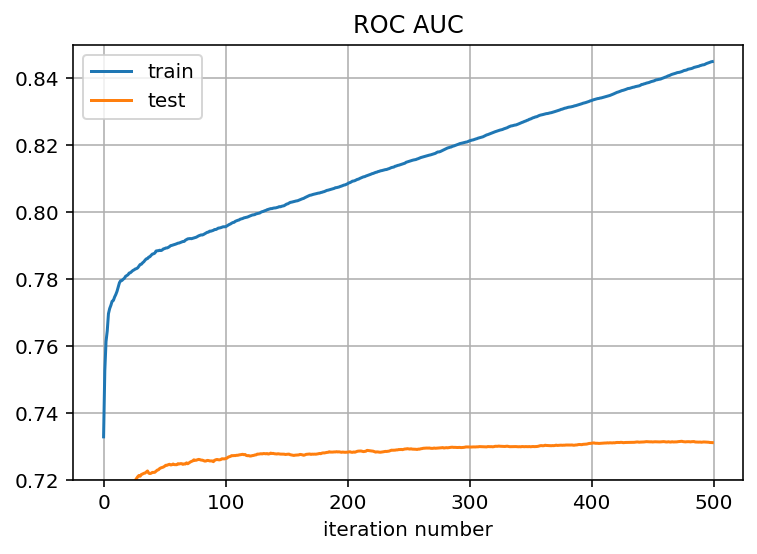

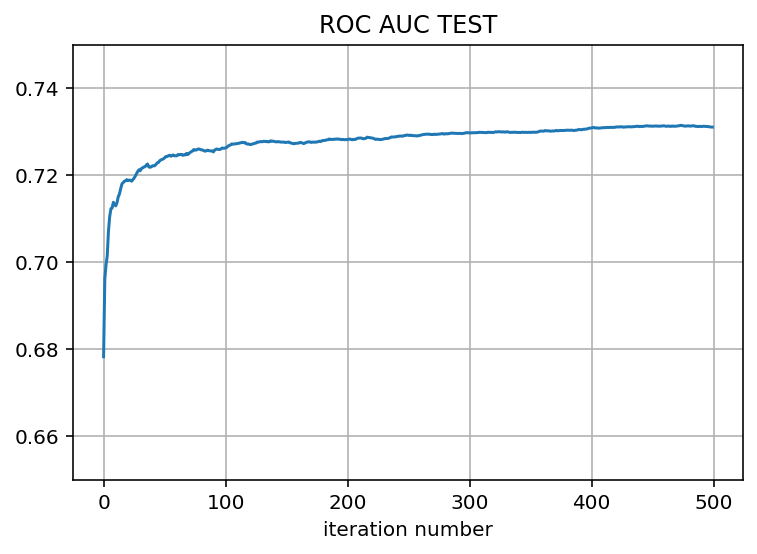

In [90]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.85), title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.65, 0.75), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

In [91]:
%%time

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 100,
         'learning_rate': 0.1
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :                                
{'colsample_bytree': 0.6000000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
[06:12:45] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.7255                                  
Training with params :                                                           
{'colsample_bytree': 0.9500000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.8, 'n_jobs': -1}
[06:12:47] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0ac76685cf763591d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TE

In [92]:
best

{'colsample_bytree': 1.0,
 'gamma': 1.0,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'subsample': 0.9500000000000001}

In [93]:
trials.best_trial

{'state': 2,
 'tid': 13,
 'spec': None,
 'result': {'loss': 0.2715574856317857, 'status': 'ok'},
 'misc': {'tid': 13,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [13],
   'gamma': [13],
   'max_depth': [13],
   'min_child_weight': [13],
   'subsample': [13]},
  'vals': {'colsample_bytree': [1.0],
   'gamma': [1.0],
   'max_depth': [3.0],
   'min_child_weight': [3.0],
   'subsample': [0.9500000000000001]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 11, 16, 3, 13, 15, 922000),
 'refresh_time': datetime.datetime(2022, 11, 16, 3, 13, 17, 742000)}

In [94]:
best_new = {'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001,
 'n_estimators': 100,
 'learning_rate': 0.1         
}

In [95]:
%%time
clf_xgb = xgb.XGBClassifier(**best_new)
clf_xgb.fit(X_train, y_train)

Wall time: 1.4 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.75, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=3.0, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Train:
ROC AUC: 0.7774
Test:
ROC AUC: 0.7284


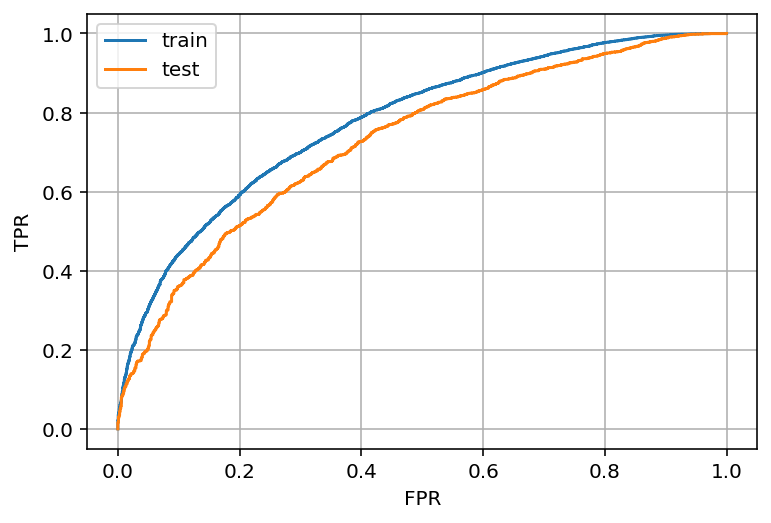

In [96]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

Wall time: 155 ms


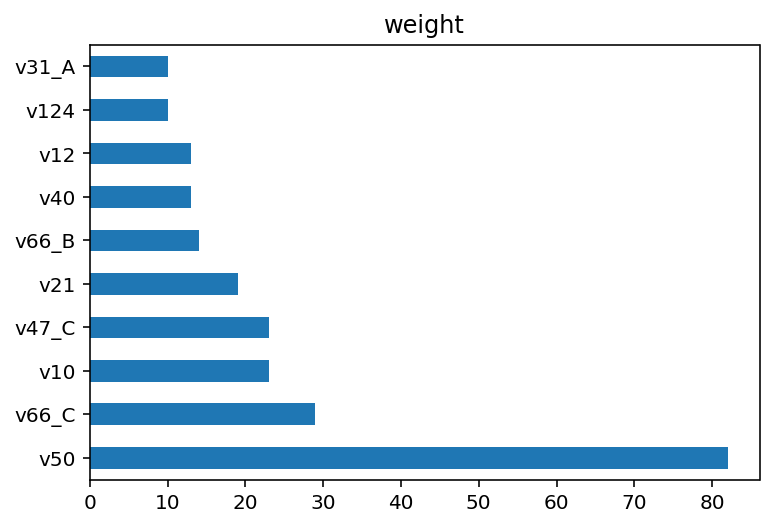

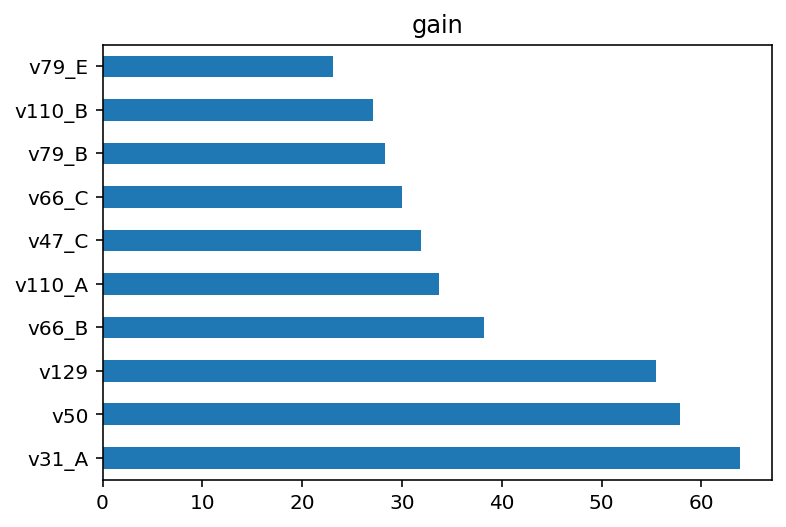

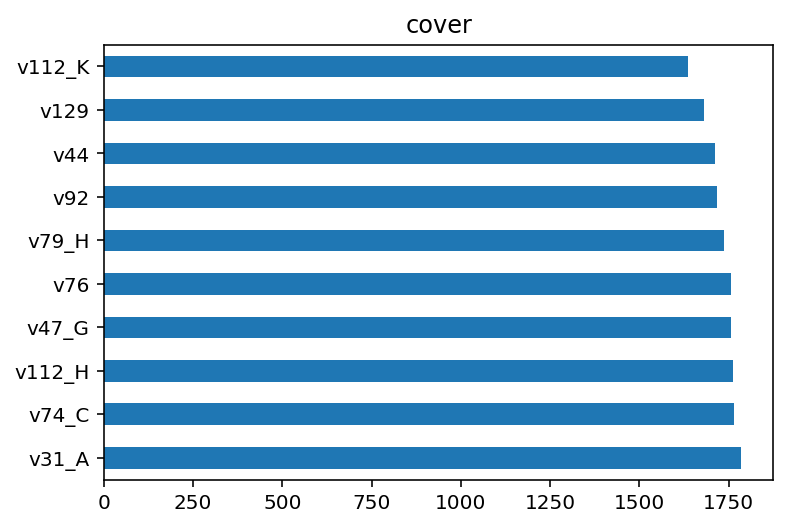

In [97]:
%%time

bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

In [ ]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

In [98]:
pd.read_excel('xgbfi_report.xlsx', engine='openpyxl', sheet_name=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,4742.588843,82,57.067903,0.695950,57.836449,3986.021180,1,1,1,11,2,1,2.833333,27.890244,0.926829
1,v66_C,869.152006,29,14.848628,0.512022,29.970759,445.568196,2,2,2,31,7,3,7.833333,21.551724,1.344828
2,v47_C,734.013384,23,12.077533,0.525110,31.913625,374.837858,3,3,3,28,6,4,7.833333,17.434783,1.695652
3,v31_A,638.934319,10,8.196577,0.819658,63.893432,610.997151,4,9,6,6,1,2,4.666667,15.800000,0.600000
4,v66_B,535.621330,14,6.261034,0.447217,38.258666,202.937504,5,6,9,45,4,5,12.333333,20.571429,1.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v112_K,19.096370,2,1.828590,0.914295,9.548185,17.243623,96,95,41,1,69,47,58.166667,67.500000,1.000000
96,v52_F,18.942901,2,0.081231,0.040615,9.471450,0.765918,97,96,98,97,72,98,93.000000,77.000000,2.000000
97,v70,18.418818,2,0.977294,0.488647,9.209409,11.630971,98,97,69,35,76,64,73.166667,61.500000,2.000000
98,v93,18.374420,2,1.176772,0.588386,9.187210,10.367085,99,98,60,18,77,70,70.333333,71.500000,1.000000


In [103]:
from catboost import CatBoostClassifier, Pool

In [104]:
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)





clf_catb = CatBoostClassifier(
                           l2_leaf_reg=4000,
                           iterations=1000,
                           learning_rate=0.3,
                           eval_metric='AUC',
                           max_depth=7,
                           loss_function='CrossEntropy',
                           use_best_model=True,
                           custom_metric=['Accuracy',
                                          'AUC:hints=skip_train~false'],
                                                     )

In [105]:
clf_catb.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train:
ROC AUC: 0.8470
Test:
ROC AUC: 0.7377


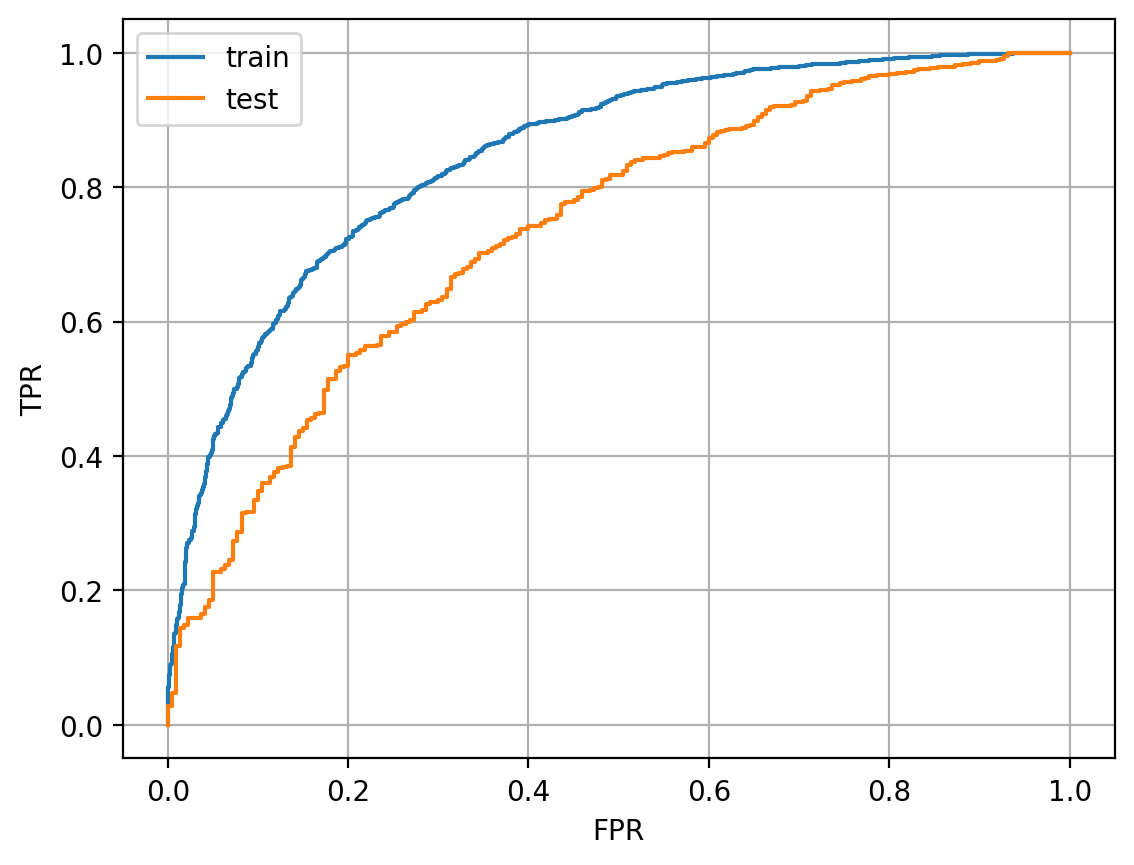

In [106]:
y_pred_catb_test = clf_catb.predict_proba(X_test)[:, 1]
y_pred_catb_train = clf_catb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_catb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_catb_test, 'test')
plt.grid()
plt.legend();

In [ ]:
voting_clf = VotingClassifier(
     estimators=[('lr', log_clf),  ('rf_1', rf_1), ('knn_1', knn_1),('et',et)],
    voting='soft')

In [109]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(random_state=42,
                                                 solver='liblinear')),
                             ('rf_1', RandomForestClassifier(random_state=42)),
                             ('knn_1', KNeighborsClassifier())],
                 voting='soft')

In [110]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,voting_clf.predict(X_test))

0.7573770491803279

In [111]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,clf_catb.predict(X_test))


0.7836065573770492